# 03.A: Naive Bayes classifiers

In [17]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

import mylib as my

## Multinomial naive Bayes classifier
Given an unseen example $\boldsymbol{x}$, we want to predict its corresponding $y$ from a set of possible classes $y_1, y_2, \dots$. We can do so by picking the $y$ such that:
$$ y = \operatorname*{argmax}_{i}\ \ P(y_i | \boldsymbol{x})$$

We can calculate $P(y_i | \boldsymbol{x})$ using the formula:
$$ P(y_i | \boldsymbol{x}) = \alpha\ P(y_i) P(\boldsymbol{x} | y_i) $$

where $\alpha$ is a normalizing factor and $P(y_i)$ is the prior probability which can be estimated from the training dataset.

What makes **naive Bayes** naive is the strong assumption that the features $x_1, x_2, x_3, \cdots, x_m$ are independent from one another. Such an assumption allows us to write:

$$P(\boldsymbol{x} | y_i) = P(x_1, x_2, x_3, \cdots, x_m| y_i) = P(x_1 | y_i)P(x_2 | y_i)P(x_3 | y_i)\cdots P(x_m | y_i)$$
 
The $P(x_j | y_i)$ is the likelihood of $x_j$ given the class $y_i$, which can be estimated from the training set as well.

In [18]:
class NaiveBayesClassifier:
    def fit(self, dataset):
        """
        Sets things up for classification by preprocessing the training dataset
        and calculating the priors
        """
        self.ds = dataset
        self.labels = self.ds.examples.iloc[:, -1].unique()
        self.prior = self.ds.examples.iloc[:, -1].value_counts() / self.ds.examples.iloc[:, -1].count()
    
    def predict(self, unseen):
        """
        Returns the most probable label (or class) for each unseen input
        """
        if unseen.ndim == 1:
            x = pd.Series(unseen, index= self.ds.features)
            prob = pd.Series(0.0, index= self.labels)
            for lbl in self.labels:
                df_per_lbl = self.ds.examples.where(self.ds.examples.iloc[:, -1] == lbl).dropna()

                likelihood = 1
                for f in self.ds.features:
                    prob_per_lbl = df_per_lbl[f].value_counts() / df_per_lbl[f].count()
                    likelihood *= prob_per_lbl[x[f]] if x[f] in prob_per_lbl else 0

                prob[lbl] = likelihood * self.prior[lbl]
                
            return prob.idxmax()
        
        else:
            return np.array([self.predict(ex) for ex in unseen])

## An example
Let's test this using the example from the textbook:

In [19]:
ds = my.DataSet(pd.DataFrame({
    'deadline': ['ur', 'ur', 'ne', 'no', 'no', 'no', 'ne', 'ne', 'ne', 'ur'],
    'party': ['Y', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'N'],
    'lazy': ['Y', 'Y', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'N'],
    'activity': ['Pa', 'St', 'Pa', 'Pa', 'Pu', 'Pa', 'St', 'tv', 'Pa', 'St']
}), y=True)

In [20]:
ds.examples

,deadline,party,lazy,y
0,ur,Y,Y,Pa
1,ur,N,Y,St
2,ne,Y,Y,Pa
3,no,Y,N,Pa
4,no,N,Y,Pu
5,no,Y,N,Pa
6,ne,N,N,St
7,ne,N,Y,tv
8,ne,Y,Y,Pa
9,ur,N,N,St


In [21]:
nb = NaiveBayesClassifier()
nb.fit(ds)
print(nb.predict(np.array(['ne', 'N', 'Y'])))

tv


In [22]:
cm = my.confusion_matrix(ds.target, nb.predict(ds.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

[[5 0 0 0]
 [0 1 0 0]
 [0 0 3 0]
 [0 0 0 1]]
Training accuracy:  1.0


## Gaussian naive Bayes classifier
The previous classifier does not work with continuous-valued features. For these features, we estimate the prior probabilities like before based on the training set. For the likelihood (conditional) probabilities, we make the assumption that they follow the normal (or Gaussian) distribution. Then we use training set to estimate the $\mu$ and $\sigma$ parameters of these Gaussian distributions.

In [23]:
class GaussianNaiveBayesClassifier:
    def fit(self, dataset):
        """
        Sets things up for classification by preprocessing the training dataset
        and calculating the priors
        """
        self.ds = dataset
        self.labels = self.ds.examples.iloc[:, -1].unique()
        self.label_column = self.ds.examples.columns[-1]
        self.prior = self.ds.examples.iloc[:, -1].value_counts() / self.ds.examples.iloc[:, -1].count()
        self.mu = self.ds.examples.groupby(self.label_column).mean()
        self.std = self.ds.examples.groupby(self.label_column).std()
    
    def predict(self, unseen):
        """
        Returns the most probable label (or class) for each unseen input
        """
        if unseen.ndim == 1:
            x = pd.Series(unseen, index= self.ds.features)
            prob = pd.Series(0.0, index= self.labels)
            for lbl in self.labels:
                df_per_lbl = self.ds.examples.where(self.ds.examples.iloc[:, -1] == lbl).dropna()
                likelihood = 1
                for f in self.ds.features:
                    likelihood *= st.norm.pdf(x[f], loc= self.mu.at[lbl, f], scale=self.std.at[lbl, f])

                prob[lbl] = likelihood * self.prior[lbl]
                
            return prob.idxmax()
        
        else:
            return np.array([self.predict(ex) for ex in unseen])

# An example

In [24]:
basis = np.array([[3, 14],[4, 4],[10, 9]])
a_ = np.concatenate((
        basis[0,0] + np.random.normal(loc=1, scale=2.5, size=(50, 1)), 
        basis[0, 1] + np.random.normal(loc=1, scale=2.6, size=(50, 1)), 
        np.full(50, -1).reshape(50,1)), axis= 1)

b_ = np.concatenate((
        basis[1,0] + np.random.normal(loc=.8, scale=2.5, size=(50, 1)), 
        basis[1, 1] + np.random.normal(loc=.8, scale=2.4, size=(50, 1)), 
        np.full(50, 0).reshape(50,1)), axis= 1)

c_ = np.concatenate((
        basis[2,0] + np.random.normal(loc=.5, scale=2.5, size=(50, 1)), 
        basis[2, 1] + np.random.normal(loc=.5, scale=2.6, size=(50, 1)), 
        np.full(50, 1).reshape(50,1)), axis= 1)
data = pd.DataFrame(np.concatenate([a_, b_, c_], axis=0), columns=['x1', 'x2', 't'])
ds = my.DataSet(data, y=True)
ds

            x1         x2    y
0     2.870744  19.163262 -1.0
1     3.923385  17.015862 -1.0
2     2.291957  10.164091 -1.0
3     2.974174  18.200478 -1.0
4     4.642427  15.204835 -1.0
..         ...        ...  ...
145  10.943682  11.203545  1.0
146  12.740521   9.801497  1.0
147  12.996722   8.536474  1.0
148  11.915384  10.491068  1.0
149  10.242799   6.534611  1.0

[150 rows x 3 columns]

In [25]:
gnb = GaussianNaiveBayesClassifier()
gnb.fit(ds)
cm = my.confusion_matrix(ds.target, gnb.predict(ds.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

[[49  0  1]
 [ 1 48  1]
 [ 1  5 44]]
Training accuracy:  0.94


10.7 s ± 568 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


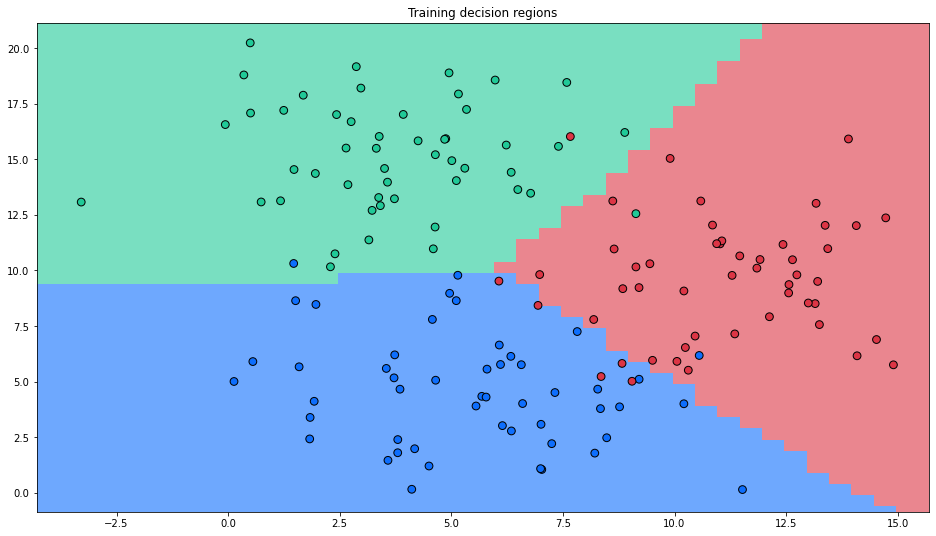

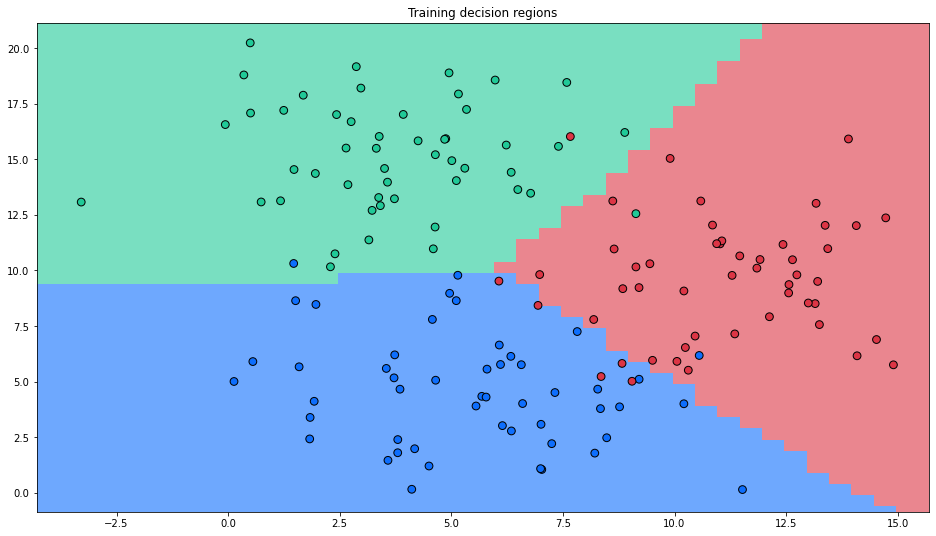

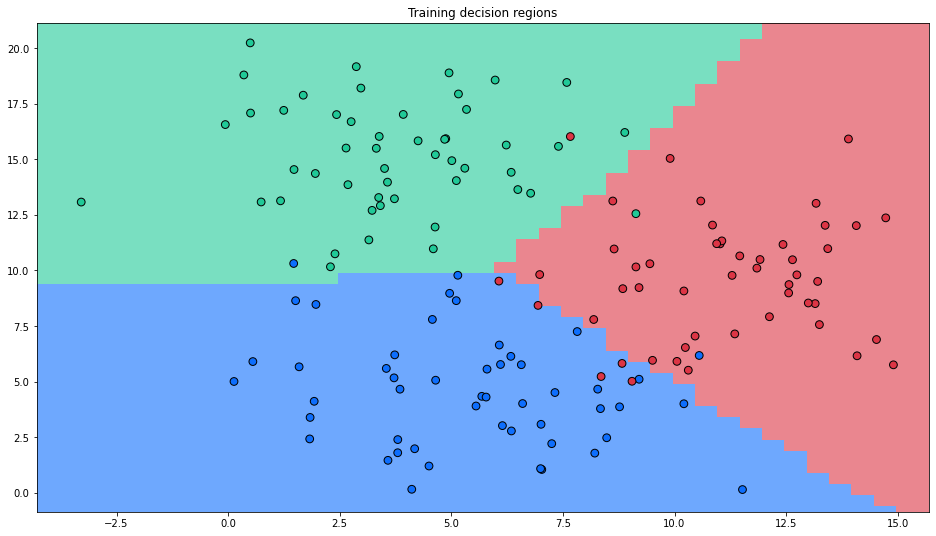

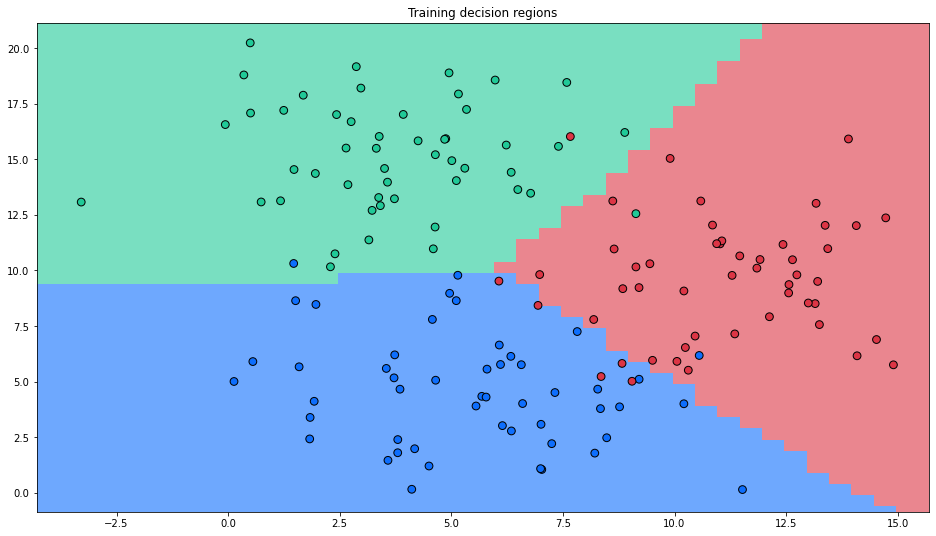

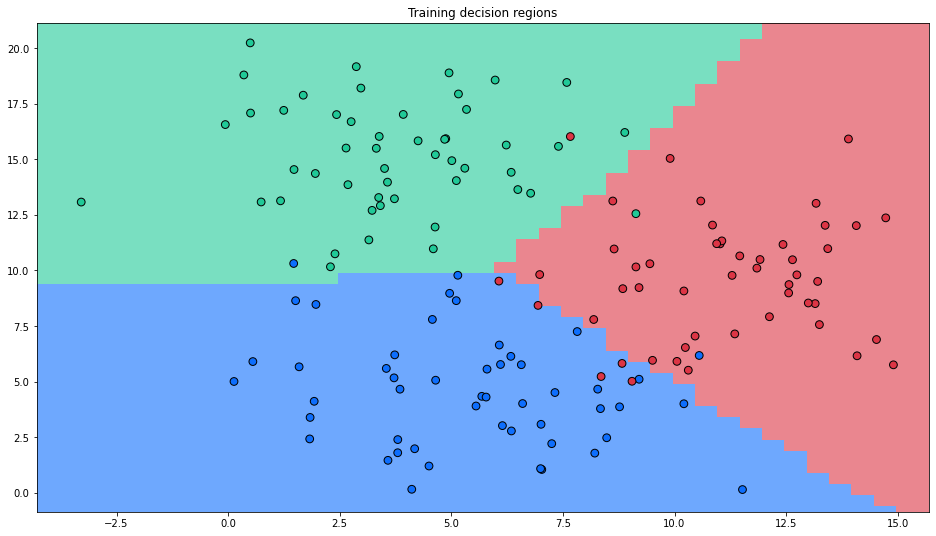

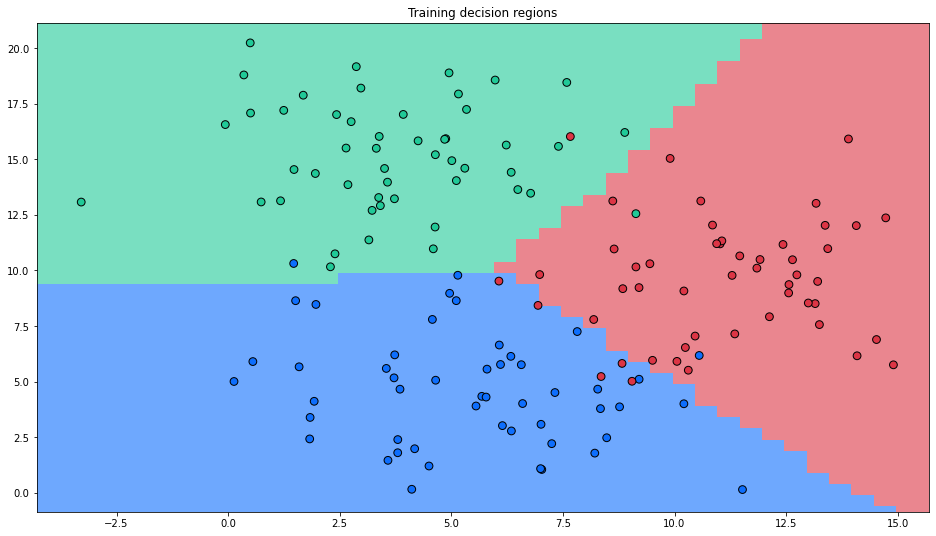

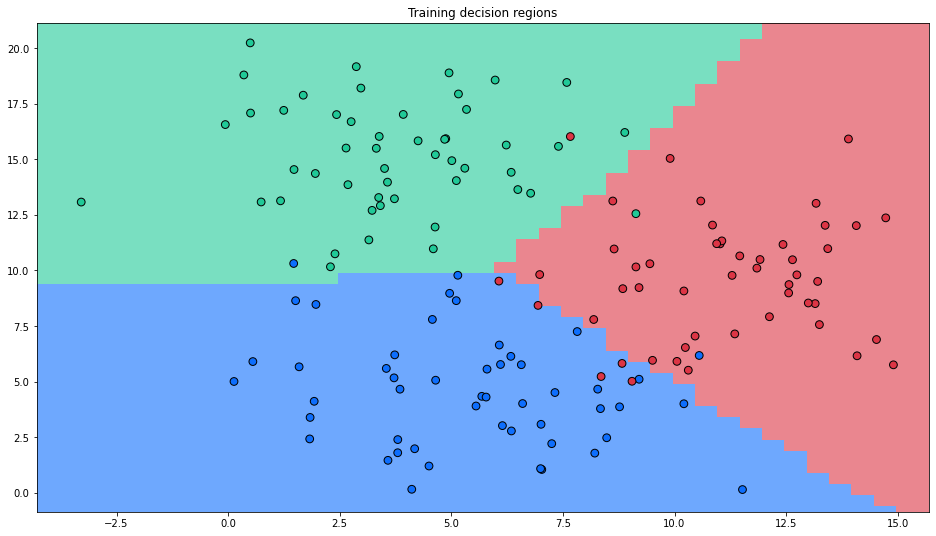

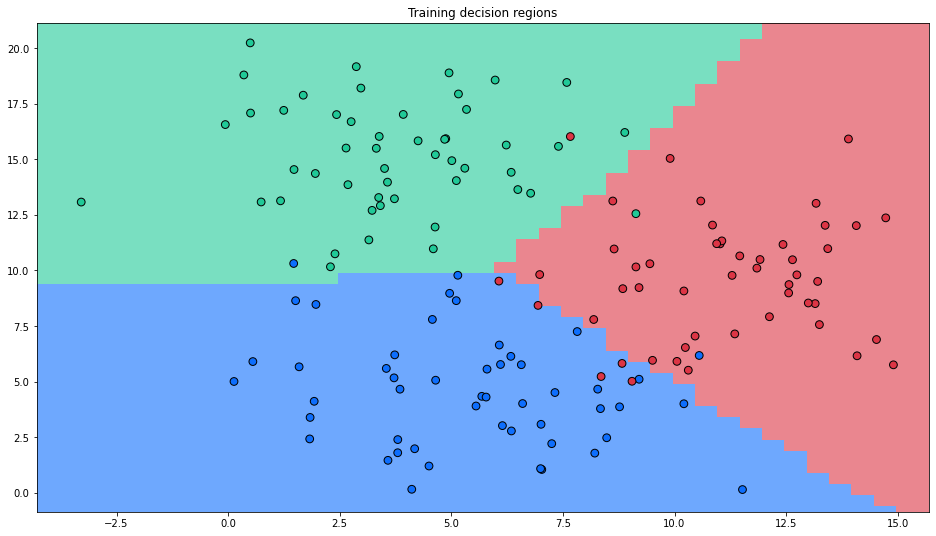

In [26]:
%%timeit
my.plot_decision_regions(ds.inputs, ds.target, gnb, resolution=0.5, title="Training decision regions")

## CHALLENGE
Re-implement the above `GaussianNaiveBayesClassifier` so as to make the `predict` method non-recursive. 
* Test your implementation and plot the decision regions of your training set.
* Benchmark your implementation using the `%%timeit` magic command against the above recursive implementation. Report any performance gain/loss you see.


In [12]:
# TODO
class GaussianNaiveBayesClassifier:
    def fit(self, dataset):
        """
        Sets things up for classification by preprocessing the training dataset
        and calculating the priors
        """
        self.ds = dataset
        self.labels = self.ds.examples.iloc[:, -1].unique()
        self.label_column = self.ds.examples.columns[-1]
        self.prior = self.ds.examples.iloc[:, -1].value_counts() / self.ds.examples.iloc[:, -1].count()
        self.mu = self.ds.examples.groupby(self.label_column).mean()
        self.std = self.ds.examples.groupby(self.label_column).std()
    
    def predict(self, unseen):
        """
        Returns the most probable label (or class) for each unseen input
        """
        for ex in unseen:
        
            if unseen.ndim == 1:
                x = pd.Series(unseen, index= self.ds.features)
                prob = pd.Series(0.0, index= self.labels)
                for lbl in self.labels:
                    df_per_lbl = self.ds.examples.where(self.ds.examples.iloc[:, -1] == lbl).dropna()
                    likelihood = 1
                    for f in self.ds.features:
                        likelihood *= st.norm.pdf(x[f], loc= self.mu.at[lbl, f], scale=self.std.at[lbl, f])

                    prob[lbl] = likelihood * self.prior[lbl]
                    
                    np.array[ex] = prob.idxmax();

        return np.array()

In [28]:

my_gnb = GaussianNaiveBayesClassifier()
my_gnb.fit(ds)
my_cm = my.confusion_matrix(ds.target, gnb.predict(ds.inputs))
my_accuracy = np.trace(my_cm) / np.sum(my_cm)

print(my_cm)
print('Training accuracy: ', my_accuracy)


[[49  0  1]
 [ 1 48  1]
 [ 1  5 44]]
Training accuracy:  0.94


10.4 s ± 333 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


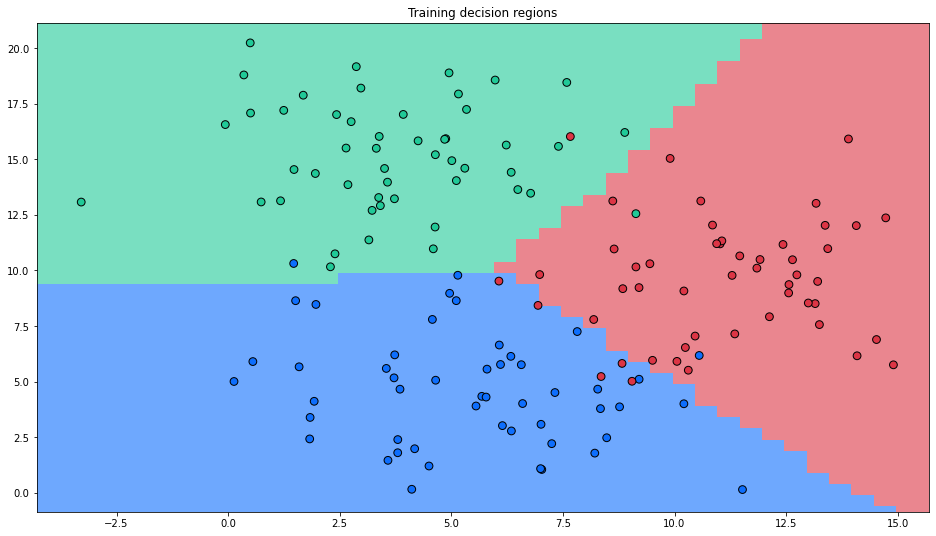

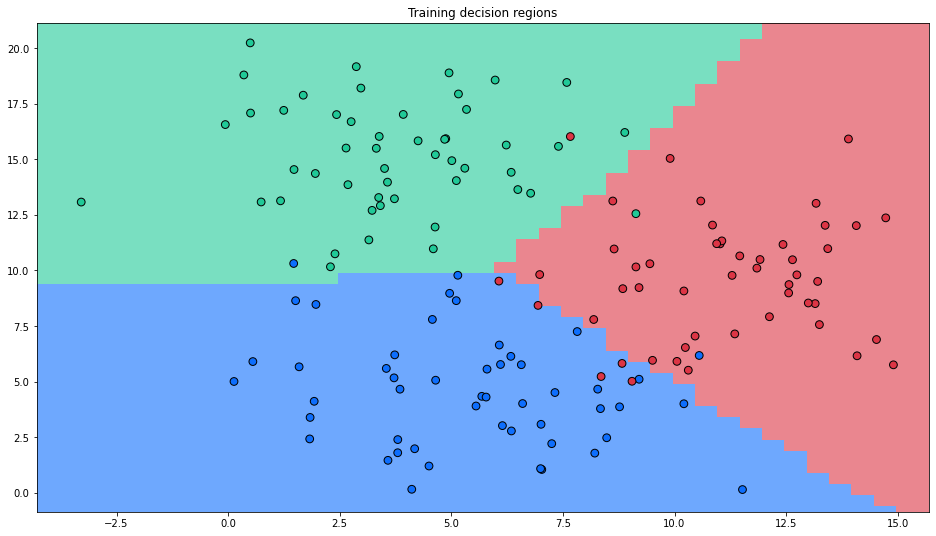

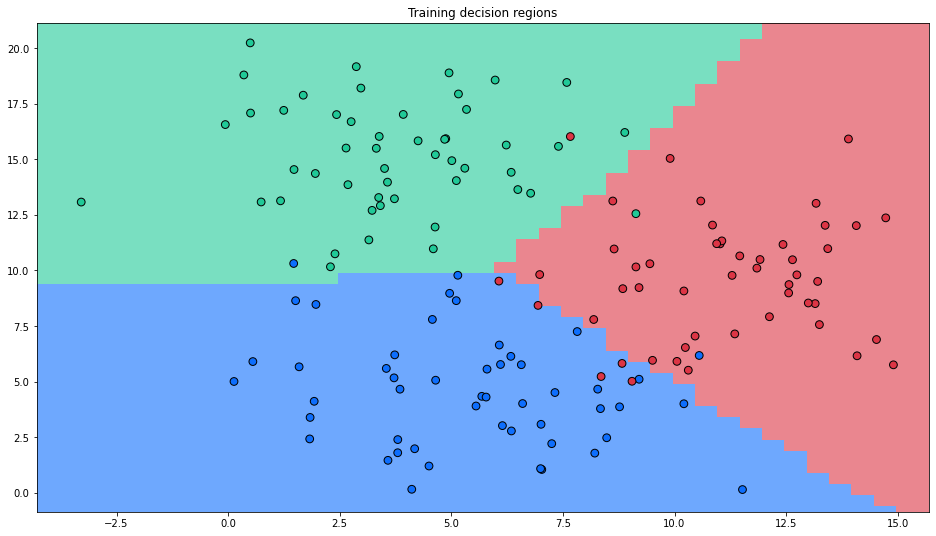

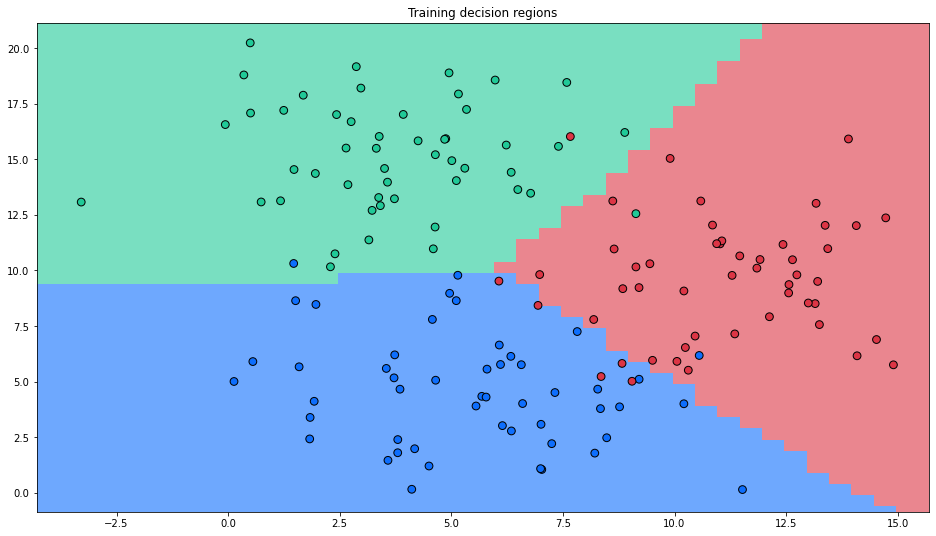

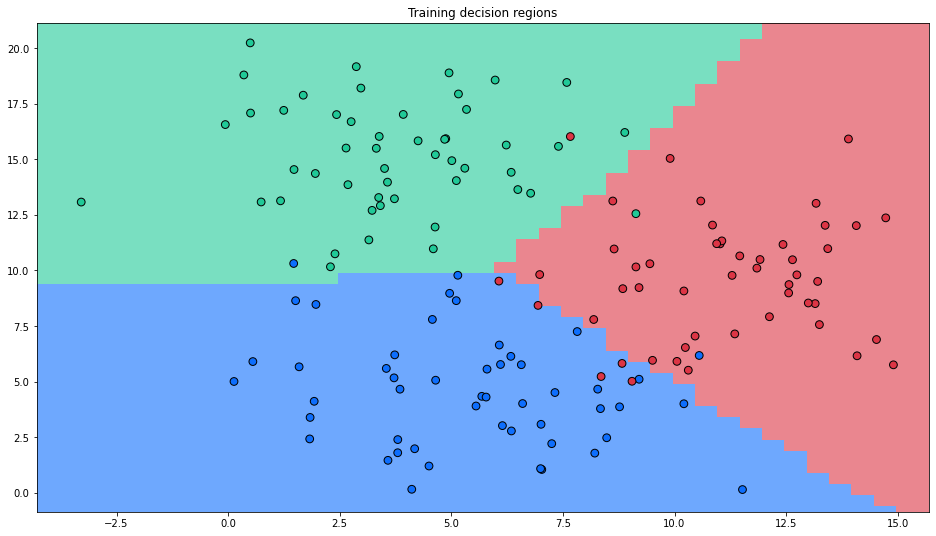

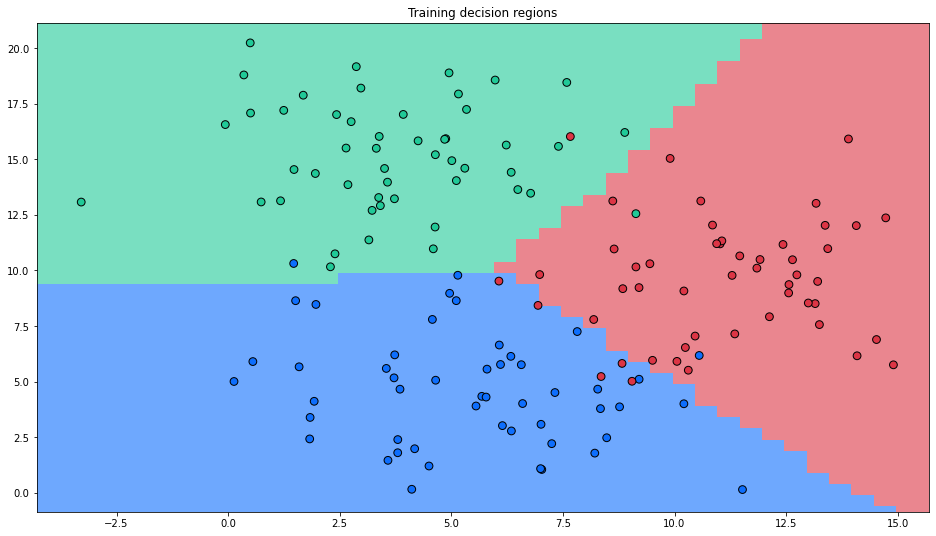

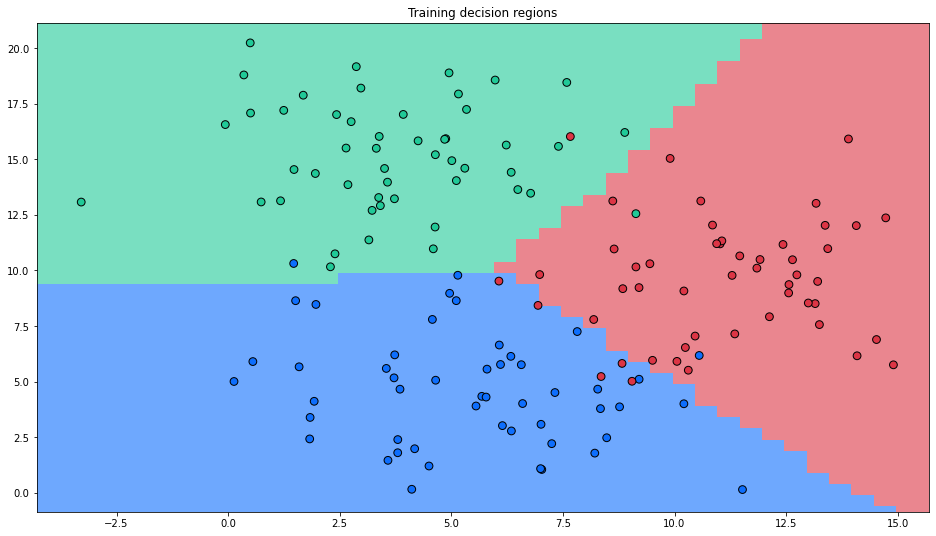

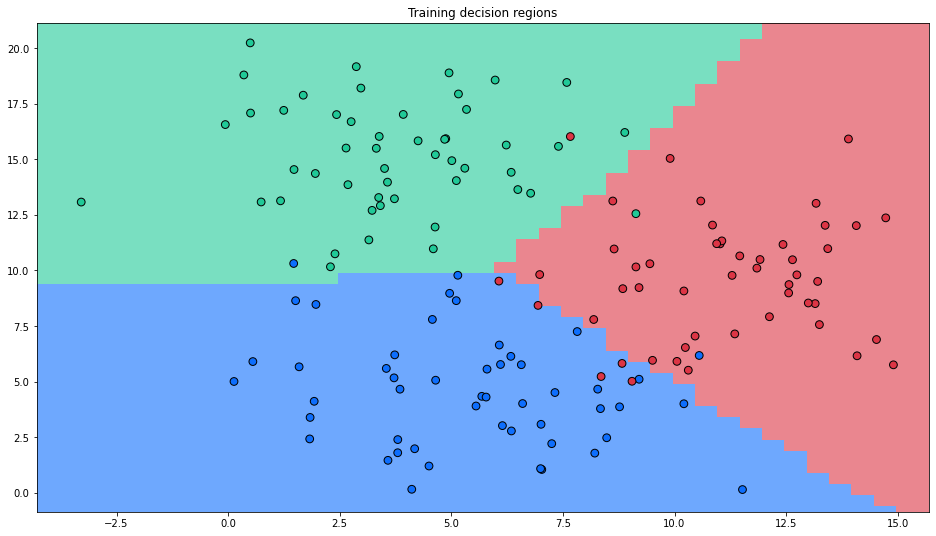

In [29]:
%%timeit
my.plot_decision_regions(ds.inputs, ds.target, my_gnb, resolution=0.5, title="Training decision regions")

My implementation with the for loop with slightly faster than the prior iteration.